# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IW2_LIACC

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import re 
import datetime

# Dataset all columns rawEEG, alpha, beta ...

### dataset function for the whole

In [ ]:
def get_dataset (users_list = ['2'],
                               #'9', '8', '7', '3', '4', '5', '2', '6', '10', '11', '12', '1'],
                 folders_list = ['DatasetA'],
                 path = '/content/drive/MyDrive/IW2_LIACC/IW_NeuroSky/'):

  '''
  to prepaire the dataset.

  users = list of users like [1,2,3,7]
  series = list of dataset names like ['DatasetA', 'DatasetB']

  '''


  data = pd.DataFrame()
  data_labels = pd.DataFrame()

  for folder_name in folders_list:

    _, dirs, _ = next(os.walk(path+folder_name))

    existed_files = set(dirs) & set(users_list)

    labels = pd.read_csv(path+folder_name+'/Labels.csv')
    labels.set_index (['File'], inplace=True)

    for user_name in existed_files:
      
      temp = path + folder_name + '/' + user_name
      _, _, files = next(os.walk(temp))

      if len (files) == 0:
        continue

      for file_name in files:

        temp = path + folder_name + '/' + user_name + '/' + file_name

        #print (temp)

        data_single_file = pd.read_csv(temp)

        label_single_file = pd.DataFrame({'label': [labels['Label'][file_name]]*data_single_file.shape[0]})
        
        data_file = pd.concat([data_single_file, label_single_file], axis =1)

        #data_single_file.concat(label_single_file, axis=1, inplace = True)

        data = data.append (data_file)
        

  return data

In [ ]:
dataset = get_dataset(users_list = ['1'],
                      folders_list = ['DatasetB'],
                      path = '/content/drive/MyDrive/IW2_LIACC/IW_NeuroSky/')
dataset.shape

to_drop = list ((dataset['label'] == 'Stop'))
dataset = dataset.iloc[to_drop]

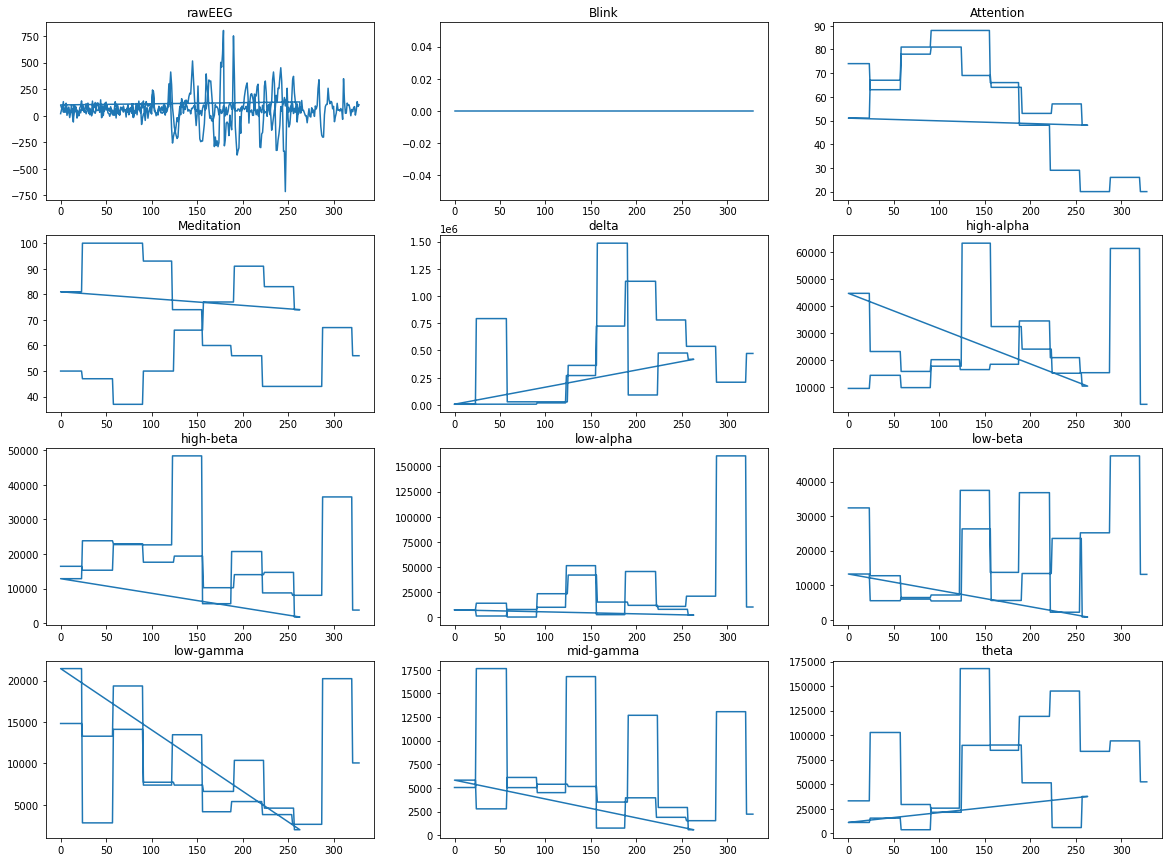

In [ ]:
fix, ax = plt.subplots(4, 3, figsize=(20, 15))



cols = dataset.drop(['time', 'label'], axis=1).columns

i=0
j=0
for x, col in enumerate (cols):
  if j == 3:
    i+=1
    j=0
  ax[i,j].plot(dataset[col])
  ax[i,j].set_title(col)
  j=j+1

In [ ]:
# extracting seconds from time stamp
dataset['extracted_seconds'] = dataset['time'].dt.second

AttributeError: ignored

In [ ]:
dataset

In [ ]:
dataset['extracted_seconds'].value_counts().sort_values()

# Other dataset

In [ ]:
other_data = pd.read_csv('/content/drive/MyDrive/IW2_LIACC/other dataset/EEG_data.csv')
other_data

In [ ]:
plt.plot(other_data['Raw'].iloc[0:200])

# dataset for rawsignal - sampling steps = 3000

In [ ]:
def get_dataset_raw_signal (users_list = ['1'],
                               #'9', '8', '7', '3', '4', '5', '2', '6', '10', '11', '12', '1'],
                 folders_list = ['DatasetA'],
                 path = '/content/drive/MyDrive/IW2_LIACC/IW_NeuroSky/',
                 signal_name ='rawEEG',
                 sampling_steps=512):

  '''
  to prepaire the dataset.

  users = list of users like [1,2,3,7]
  series = list of dataset names like ['DatasetA', 'DatasetB']

  '''

  data = pd.DataFrame()

  for folder_name in folders_list:

    _, dirs, _ = next(os.walk(path+folder_name))

    existed_files = set(dirs) & set(users_list)

    labels = pd.read_csv(path+folder_name+'/Labels.csv')
    labels.set_index (['File'], inplace=True)

    for user_name in existed_files:
      
      temp = path + folder_name + '/' + user_name
      _, _, files = next(os.walk(temp))

      if len (files) == 0:
        continue

      for file_name in files:

        temp = path + folder_name + '/' + user_name + '/' + file_name

        #print (temp)
        
        temp_dataset = pd.read_csv(temp)

        data_single_file = temp_dataset[signal_name]

        num_of_samples = np.floor(data_single_file.shape[0]/sampling_steps)
        
        for i in range(0,int(num_of_samples)):
          one_sample_df = data_single_file.iloc[i*sampling_steps:(i+1)*sampling_steps]
          transposed_data = pd.DataFrame((np.array(one_sample_df).reshape(1,-1)))
          shape_t = transposed_data.shape[1]
          transposed_data['label'] = pd.DataFrame({'label': [labels['Label'][file_name]]*shape_t})
          transposed_data['time'] = temp_dataset['time'].iloc[i*sampling_steps:(i+1)*sampling_steps]
          data = pd.concat([data, transposed_data], axis =0)

  return data

In [ ]:
data = get_dataset_raw_signal (users_list = ['1', '9', '8', '7', '3', '4', '5', '2', '6', '10', '11', '12', '1'],
                               folders_list = ['DatasetA', 'DatasetB', 'DatasetC'],
                               path = '/content/drive/MyDrive/IW2_LIACC/IW_NeuroSky/',
                               signal_name ='rawEEG',
                               sampling_steps=3000)

# Try 1

# Pre-processing for time sampling steps of 1 sec

---



### dataset for rawsignals plus resampling  

In [ ]:
from scipy import signal

In [ ]:
from pandas.core import resample
def get_dataset_raw_signal_resampling (users_list = ['1'],
                                                     #,'9', '8', '7', '3', '4', '5', '2', '6', '10', '11', '12'],
                 folders_list = ['DatasetA'],
                 #, 'DatasetB', 'DatasetC'],
                 path = '/content/drive/MyDrive/IW2_LIACC/IW_NeuroSky/',
                 signal_name ='rawEEG'):

  '''
  to prepaire the dataset.

  users = list of users like [1,2,3,7]
  series = list of dataset names like ['DatasetA', 'DatasetB']

  '''

  data = pd.DataFrame()
  user_labels = pd.DataFrame()
  all_labels = pd.DataFrame()

  for folder_name in folders_list:

    _, dirs, _ = next(os.walk(path+folder_name))

    existed_files = set(dirs) & set(users_list)

    labels = pd.read_csv(path+folder_name+'/Labels.csv')
    labels.set_index (['File'], inplace=True)

    for user_name in existed_files:
      
      temp = path + folder_name + '/' + user_name
      _, _, files = next(os.walk(temp))

      if len (files) == 0:
        continue

      for file_name in files:

        temp = path + folder_name + '/' + user_name + '/' + file_name

        #print (temp)
        
        temp_dataset = pd.read_csv(temp)
        temp_dataset['time'] = pd.to_datetime(temp_dataset['time'], format='%H:%M:%S')
        temp_dataset['second'] = temp_dataset['time'].dt.second

        for sec in temp_dataset['second'].unique():

          boolian_mask = (temp_dataset['second']==sec).to_list()
          a_sec = temp_dataset.iloc[boolian_mask]
          resampled_data = signal.resample( a_sec[signal_name] , 128)
          resampled_data = resampled_data.reshape (1,-1)
          resampled_data_df = pd.DataFrame(resampled_data)
          shape_t = resampled_data_df.shape[1]
          user_labels = pd.DataFrame({'label': [labels['Label'][file_name]]*shape_t})
          resampled_data_df['label'] = user_labels

          #all_labels = pd.concat([all_labels, user_labels], axis =1)
          data = pd.concat([data, resampled_data_df], axis =0, ignore_index=True)



  return data

In [ ]:
dataset = get_dataset_raw_signal_resampling()
dataset 

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-13.315296,68.002748,32.901835,43.707761,61.144271,76.511506,40.609026,59.637298,46.964167,52.777882,...,400.573471,282.425588,193.230893,174.012184,189.517261,201.007825,128.340896,154.772406,43.562520,Left
1,-21.489392,-230.584760,-113.904247,-343.816747,-568.899562,-715.559617,-769.276090,-809.336729,-767.595732,-740.226943,...,101.958709,101.587376,80.946250,15.817542,82.191335,39.764888,48.082430,13.307180,40.020937,Left
2,-7.165716,62.168850,68.860368,42.850619,30.468882,31.664639,73.585517,85.980628,23.127977,38.915244,...,-39.390966,-32.194750,-77.155614,-60.258974,-68.965230,-29.897243,-8.819296,7.531446,-6.510732,Left
3,-2.948527,6.901589,32.792562,92.502563,69.498935,31.317609,56.887419,5.061141,-11.658163,41.517598,...,84.573706,34.713949,72.520905,38.294118,83.736074,70.173130,59.552944,35.982100,61.212447,Left
4,29.339019,83.100219,55.985143,75.936553,87.576271,68.007971,100.846478,59.808031,45.038015,38.825268,...,87.517633,94.880400,86.550270,96.331262,84.096693,101.663112,48.404472,24.865532,41.337511,Left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,69.949413,50.915689,53.358253,57.526439,41.385517,13.967523,64.878177,83.007330,46.893980,27.601989,...,61.591748,64.478526,92.603139,70.643955,68.313423,66.784510,41.809101,44.132681,69.335099,Stop
57,78.800967,82.685757,70.258098,56.914570,19.791281,55.615335,54.192531,55.670127,33.826228,20.535376,...,60.975623,57.520697,60.205026,57.865887,60.425275,55.940667,72.572232,102.970198,56.921678,Stop
58,45.291381,79.306267,82.477014,66.578401,55.955212,49.512614,47.813465,49.934500,-1.183295,16.569656,...,74.727101,56.691331,77.949084,66.131498,43.575736,51.005227,71.619838,68.214373,-2.602670,Stop
59,51.572435,56.172648,75.944886,48.066182,-36.141862,37.809222,96.758519,55.464134,35.685559,22.427860,...,51.546407,81.719403,63.710931,41.183374,33.689356,97.524507,93.937230,62.459837,81.963674,Stop


### filter + normalization

In [ ]:
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
import pandas as pd
import csv
import statistics 
from scipy import signal
from datetime import datetime
from math import factorial
from sklearn import preprocessing

#butter_bandpass to remove noise
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Normalization
def feature_normalize(dataset): 
    return (dataset - min(dataset))/(max(dataset) - min(dataset))


def preprocessing_data_raw(raw_data, fs, order=5):  # Apply a bandpass filter on the raw eeg
    label = raw_data['label']
    data = raw_data.drop(['label'], axis=1)
    data = butter_bandpass_filter(data, 4, 45 , fs , order=order)
    return pd.DataFrame(data)

def feature_normalize(dataset):
    #dataset = dataset.drop(['label'], axis=1 ) 
    return (dataset - min(dataset))/(max(dataset) - min(dataset))

In [ ]:
fs=128
data = preprocessing_data_raw (dataset, fs=fs)

In [ ]:
data = feature_normalize(data)
data['label'] = dataset['label']

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.014766,0.039521,0.224396,0.175244,-0.117191,-0.050822,0.042275,-0.253224,-0.270759,-0.065856,...,-0.495146,-0.305194,-0.460887,-0.628421,0.108075,0.936902,1.037046,0.946857,0.912276,Left
1,-0.023830,-0.313620,-0.740350,-0.508665,-0.411304,-1.287936,-0.969402,0.658103,1.332656,1.786946,...,-0.494690,-0.350656,-0.311448,-0.335042,-0.304645,0.019818,0.322832,0.186866,0.203806,Left
2,-0.007946,0.049626,0.246412,0.244743,-0.149920,-0.333750,-0.102841,0.062139,-0.005381,-0.257696,...,-0.302918,-0.567473,-1.022349,-1.182850,-1.041844,-0.882207,-0.594259,-0.368077,-0.349574,Left
3,-0.003270,-0.000294,0.055990,0.202231,0.288283,0.023107,-0.354591,-0.317090,-0.242887,-0.328522,...,0.153059,0.062292,-0.007132,-0.045638,0.001793,0.071175,0.033776,-0.117581,-0.189531,Left
4,0.032535,0.171229,0.275881,0.070316,-0.154957,-0.096503,-0.143486,-0.259388,-0.242845,-0.337201,...,0.024921,0.042539,0.042897,0.049947,0.052497,0.049235,0.016926,-0.133873,-0.218570,Left


### functions for feature extraction

In [ ]:
dataset_fea = dataset.drop('label', axis =1)
dataset_fea['test'] = dataset_fea.apply (detrended_fluctuation, axis=1)

In [ ]:
dataset_fea['test'].var()

2.437319042169924e-05

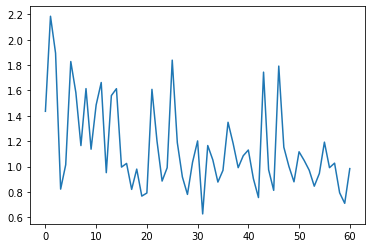

In [ ]:
plt.plot(dataset_fea['test'])

#### statistics

In [ ]:
def mean():
  return np.mean

def var():
  return np.std

def test(x):
  
  return x.shape[0]

def skewness (x):

  N = x.shape[0]
  row_mean = np.mean(x)
  row = np.array(x)

  num = np.sum(np.power((row - row_mean), 3))*1/N
  dnom_0 = np.sum(np.power((row - row_mean), 2))*(1/(N-1))
  dnom = np.power(dnom_0,3/2)

  return num/dnom


def kurtosis (x):

  N = x.shape[0]
  row_mean = np.mean(x)
  row = np.array(x)

  num = np.sum(np.power((row - row_mean), 4))*1/N
  dnom_0 = np.sum(np.power((row - row_mean), 2))*1/N
  dnom = np.power(dnom_0, 2)

  return num/dnom


def hjorth_parameters(d):
  
    """Hjorth parameters
    Parameters
    ----------
    d : 
      Time series data 
    
    Returns
    -------
    activity, complexity and mobility 
    
    Notes
    -----"""  

    #Compute Hjorth parameters

    first_deriv = np.diff(d)
    second_deriv = np.diff(d,2)

    var_zero = np.mean(d ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

  
def hjorth_activity (d):
    
    activity, _, _ = hjorth_parameters(d)

    return activity


def hjorth_mobilty (d):
    
    _, mobility, _ = hjorth_parameters(d)

    return mobility


def hjorth_complexity (d):
    
    _, _, complexity = hjorth_parameters(d)

    return complexity


def feature_normalize(x): 

    return (x - min(x))/(max(x) - min(x))


def abs_mean (x):

  abs_mean = np.mean(np.absolute(feature_normalize(x) - np.mean(feature_normalize(x))))
  
  return abs_mean

#### helper

In [ ]:
# helper
@jit('UniTuple(float64, 2)(float64[:], float64[:])', nopython=True)
def _linear_regression(x, y):
    """Fast linear regression using Numba.

    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables

    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept 


@jit('i8[:](f8, f8, f8)', nopython=True)
def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.

    Used for detrended fluctuation analysis (DFA).

    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.

    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)

    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)


def _app_samp_entropy(x, order, metric='chebyshev', approximate=True):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    phi = np.zeros(2)
    r = 0.2 * np.std(x, ddof=0)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    if approximate:
        emb_data1 = _emb_data1
    else:
        emb_data1 = _emb_data1[:-1]
    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    # compute phi(order + 1, r)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    if approximate:
        phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
        phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
    else:
        phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
        phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


@jit('f8(f8[:], i4, f8)', nopython=True)
def _numba_sampen(x, order, r):
    """
    Fast evaluation of the sample entropy using Numba.
    """
    n = x.size
    n1 = n - 1
    order += 1
    order_dbld = 2 * order

    # Define threshold
    # r *= x.std()

    # initialize the lists
    run = [0] * n
    run1 = run[:]
    r1 = [0] * (n * order_dbld)
    a = [0] * order
    b = a[:]
    p = a[:]

    for i in range(n1):
        nj = n1 - i

        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - x[i]) < r:
                run[jj] = run1[jj] + 1
                m1 = order if order < run[jj] else run[jj]
                for m in range(m1):
                    a[m] += 1
                    if j < n1:
                        b[m] += 1
            else:
                run[jj] = 0
        for j in range(order_dbld):
            run1[j] = run[j]
            r1[i + n * j] = run[j]
        if nj > order_dbld - 1:
            for j in range(order_dbld, nj):
                run1[j] = run[j]

    m = order - 1

    while m > 0:
        b[m] = b[m - 1]
        m -= 1

    b[0] = n * n1 / 2
    a = np.array([float(aa) for aa in a])
    b = np.array([float(bb) for bb in b])
    p = np.true_divide(a, b)
    return -log(p[-1])




In [ ]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.

    Parameters
    ----------
    x : 1d-array
        Time series, of shape (n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.

    Returns
    -------
    embedded : ndarray
        Embedded time-series, of shape (n_times - (order - 1) * delay, order)
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[(i * delay):(i * delay + Y.shape[1])]
    return Y.T

#### FD

In [ ]:
import numpy as np
from numba import jit
from math import log, floor

#from .utils import _linear_regression, _log_n
# all = ['petrosian_fd', 'katz_fd', 'higuchi_fd', 'detrended_fluctuation']


def petrosian_fd(x):
  
    n = len(x)
    # Number of sign changes in the first derivative of the signal
    diff = np.ediff1d(x)
    N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
    
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))


def katz_fd(x):

    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))

    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))


#@jit('float64(float64[:], int32)')
def _higuchi_fd(x, kmax):

    """Utility function for `higuchi_fd`.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)


def detrended_fluctuation(x):
    x = np.asarray(x, dtype=np.float64)
    return _dfa(x)


#### entropy

In [ ]:
import numpy as np
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy', 'lziv_complexity']


def perm_entropy(x, order=3, delay=1, normalize=False):
    """Permutation Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy. Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    pe : float
        Permutation Entropy.
  
    """
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def spectral_entropy(x, sf=128, method='fft', nperseg=None, normalize=False):
    """Spectral Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    sf : float
        Sampling frequency, in Hz.
    method : str
        Spectral estimation method:

        * ``'fft'`` : Fourier Transform (:py:func:`scipy.signal.periodogram`)
        * ``'welch'`` : Welch periodogram (:py:func:`scipy.signal.welch`)
    nperseg : int or None
        Length of each FFT segment for Welch method.
        If None (default), uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.

    Returns
    -------
    se : float
        Spectral Entropy
    """
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se


def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of SVD entropy (= length of the embedding dimension).
        Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    svd_e : float
        SVD Entropy

    """
    
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e



def app_entropy(x, order=2, metric='chebyshev'):
    """Approximate Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.

    Returns
    -------
    ae : float
        Approximate Entropy.
    """
    
    phi = _app_samp_entropy(x, order=order, metric=metric, approximate=True)
    return np.subtract(phi[0], phi[1])


def sample_entropy(x, order=2, metric='chebyshev'):
    """Sample Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.

    Returns
    -------
    se : float
        Sample Entropy.
    """

    x = np.asarray(x, dtype=np.float64)
    if metric == 'chebyshev' and x.size < 5000:
        return _numba_sampen(x, order=order, r=(0.2 * x.std(ddof=0)))
    else:
        phi = _app_samp_entropy(x, order=order, metric=metric,
                                approximate=False)
        return -np.log(np.divide(phi[1], phi[0]))


In [ ]:
dataset_fea = dataset.drop('label', axis =1)
dataset_fea['test'] = dataset_fea.apply (detrended_fluctuation, axis=1)


#### EMD

In [ ]:

#time freq domain: EMD/ IMF features
def imf_feat(imfs,x):
    """EMD/ IMF features
    Parameters
    ----------
    imfs : Estimate IMFs
        
    Returns
    -------
    Dts, Dp, Enorm, EnormFeat: First Difference of IMF Time Series, First difference of phase, Normalized Energy of IMF,
        
    Notes
    -----"""    
    imfs_feat={}
    sumIMF = 0
    sumPhase = 0 
    sumIMF2 = 0
    for i in range(len(imfs)-1):
        
        #First Difference of IMF Time Series
        d = abs(imfs[i+1]-imfs[i])
        sumIMF = sumIMF + d
        
        #First Difference of IMF’s Phase
        instantaneous_phase = abs(np.unwrap(np.angle(hilbert(imfs[i+1])))-np.unwrap(np.angle(hilbert(imfs[i]))))
        sumPhase = sumPhase + instantaneous_phase
        
        #Normalized Energy of IMF
        imf = imfs[i]
        sumIMF2 = sumIMF2 + imf**2
    
    
    if len(imfs)>1:
        #Based on zhuang2017 paper
        Dts = (1/(len(imfs)-1))*sumIMF #First Difference of IMF Time Series
        Dp = (1/(len(imfs)-1))*sumPhase #First difference of phase 
        Enorm = sumIMF2/(len(imfs)*(x**2)) #Normalized Energy of IMF
        EnormFeat = np.log(Enorm)
        
    else: 
        #Based on zhuang2017 paper
        Dts = (1/(len(imfs)))*sumIMF #First Difference of IMF Time Series
        Dp = (1/(len(imfs)))*sumPhase #First difference of phase 
        Enorm = sumIMF2/(len(imfs)*(x**2)) #Normalized Energy of IMF
        EnormFeat = np.log(Enorm)
        
        
    return Dts, Dp, Enorm, EnormFeat


In [ ]:
##EMD/ IMF features
        for w in waves:
            x = np.array(data_pre[w]) 
            imfs = emd.sift.sift(x)
            feat_imf = imf_feat(np.transpose(imfs),x)
            imfT.append(feat_imf)
            
            #Calculate the max/mean/std values of the imfs  features
            aux_pre=[]
            k = list(feat_imf.keys())
            for k_i in range(len(k)):
                param = constant_param(feat_imf[k[k_i]])
                p_keys = list(param.keys())
                for l in p_keys:
                    key = l+k[k_i]+w
                    if key in IMF_feat.keys():
                        IMF_feat[key].append(param[l])                    
                    else:
                        IMF_feat.update({key:list([param[l]])}) 
                   

# helper functions from patricia

### utils file: Helper functions

In [ ]:
import numpy as np
from numba import jit
from math import log, floor

all = ['_embed', '_linear_regression', '_log_n']


def _embed(x, order=3, delay=1):
    """Time-delay embedding.

    Parameters
    ----------
    x : 1d-array
        Time series, of shape (n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.

    Returns
    -------
    embedded : ndarray
        Embedded time-series, of shape (n_times - (order - 1) * delay, order)
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[(i * delay):(i * delay + Y.shape[1])]
    return Y.T


@jit('UniTuple(float64, 2)(float64[:], float64[:])', nopython=True)
def _linear_regression(x, y):
    """Fast linear regression using Numba.

    Parameters
    ----------
    x, y : ndarray, shape (n_times,)
        Variables

    Returns
    -------
    slope : float
        Slope of 1D least-square regression.
    intercept : float
        Intercept
    """
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept


@jit('i8[:](f8, f8, f8)', nopython=True)
def _log_n(min_n, max_n, factor):
    """
    Creates a list of integer values by successively multiplying a minimum
    value min_n by a factor > 1 until a maximum value max_n is reached.

    Used for detrended fluctuation analysis (DFA).

    Function taken from the nolds python package
    (https://github.com/CSchoel/nolds) by Christopher Scholzel.

    Parameters
    ----------
    min_n (float):
        minimum value (must be < max_n)
    max_n (float):
        maximum value (must be > min_n)
    factor (float):
       factor used to increase min_n (must be > 1)

    Returns
    -------
    list of integers:
        min_n, min_n * factor, min_n * factor^2, ... min_n * factor^i < max_n
        without duplicates
    """
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)


### entpy_entropy file: Entropy functions

In [ ]:
import numpy as np
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch

#from .utils import _embed

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy', 'lziv_complexity']


def perm_entropy(x, order=3, delay=1, normalize=False):
    """Permutation Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of permutation entropy. Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    pe : float
        Permutation Entropy.

    Notes
    -----
    The permutation entropy is a complexity measure for time-series first
    introduced by Bandt and Pompe in 2002.

    The permutation entropy of a signal :math:`x` is defined as:

    .. math:: H = -\\sum p(\\pi)\\log_2(\\pi)

    where the sum runs over all :math:`n!` permutations :math:`\\pi` of order
    :math:`n`. This is the information contained in comparing :math:`n`
    consecutive values of the time series. It is clear that
    :math:`0 ≤ H (n) ≤ \\log_2(n!)` where the lower bound is attained for an
    increasing or decreasing sequence of values, and the upper bound for a
    completely random system where all :math:`n!` possible permutations appear
    with the same probability.

    The embedded matrix :math:`Y` is created by:

    .. math::
        y(i)=[x_i,x_{i+\\text{delay}}, ...,x_{i+(\\text{order}-1) *
        \\text{delay}}]

    .. math:: Y=[y(1),y(2),...,y(N-(\\text{order}-1))*\\text{delay})]^T

    References
    ----------
    Bandt, Christoph, and Bernd Pompe. "Permutation entropy: a
    natural complexity measure for time series." Physical review letters
    88.17 (2002): 174102.

    Examples
    --------
    Permutation entropy with order 2

    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value in bit between 0 and log2(factorial(order))
    >>> print(f"{ent.perm_entropy(x, order=2):.4f}")
    0.9183

    Normalized permutation entropy with order 3

    >>> # Return a value comprised between 0 and 1.
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    0.5888

    Fractional Gaussian noise with H = 0.5

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    0.9998

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    0.9926

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    0.9959

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.perm_entropy(rng.random(1000), normalize=True):.4f}")
    0.9997

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    0.4463

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.perm_entropy(x, normalize=True):.4f}")
    -0.0000
    """
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
    """Spectral Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    sf : float
        Sampling frequency, in Hz.
    method : str
        Spectral estimation method:

        * ``'fft'`` : Fourier Transform (:py:func:`scipy.signal.periodogram`)
        * ``'welch'`` : Welch periodogram (:py:func:`scipy.signal.welch`)
    nperseg : int or None
        Length of each FFT segment for Welch method.
        If None (default), uses scipy default of 256 samples.
    normalize : bool
        If True, divide by log2(psd.size) to normalize the spectral entropy
        between 0 and 1. Otherwise, return the spectral entropy in bit.

    Returns
    -------
    se : float
        Spectral Entropy

    Notes
    -----
    Spectral Entropy is defined to be the Shannon entropy of the power
    spectral density (PSD) of the data:

    .. math:: H(x, sf) =  -\\sum_{f=0}^{f_s/2} P(f) \\log_2[P(f)]

    Where :math:`P` is the normalised PSD, and :math:`f_s` is the sampling
    frequency.

    References
    ----------
    Inouye, T. et al. (1991). Quantification of EEG irregularity by
    use of the entropy of the power spectrum. Electroencephalography
    and clinical neurophysiology, 79(3), 204-210.

    https://en.wikipedia.org/wiki/Spectral_density

    https://en.wikipedia.org/wiki/Welch%27s_method

    Examples
    --------
    Spectral entropy of a pure sine using FFT

    >>> import numpy as np
    >>> import entropy as ent
    >>> sf, f, dur = 100, 1, 4
    >>> N = sf * dur # Total number of discrete samples
    >>> t = np.arange(N) / sf # Time vector
    >>> x = np.sin(2 * np.pi * f * t)
    >>> np.round(ent.spectral_entropy(x, sf, method='fft'), 2)
    0.0

    Spectral entropy of a random signal using Welch's method

    >>> np.random.seed(42)
    >>> x = np.random.rand(3000)
    >>> ent.spectral_entropy(x, sf=100, method='welch')
    6.980045662371389

    Normalized spectral entropy

    >>> ent.spectral_entropy(x, sf=100, method='welch', normalize=True)
    0.9955526198316071

    Fractional Gaussian noise with H = 0.5

    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.9505

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.8477

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.spectral_entropy(x, sf=100, normalize=True):.4f}")
    0.9248
    """
    x = np.array(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd, psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se


def svd_entropy(x, order=3, delay=1, normalize=False):
    """Singular Value Decomposition entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times)
    order : int
        Order of SVD entropy (= length of the embedding dimension).
        Default is 3.
    delay : int
        Time delay (lag). Default is 1.
    normalize : bool
        If True, divide by log2(order!) to normalize the entropy between 0
        and 1. Otherwise, return the permutation entropy in bit.

    Returns
    -------
    svd_e : float
        SVD Entropy

    Notes
    -----
    SVD entropy is an indicator of the number of eigenvectors that are needed
    for an adequate explanation of the data set. In other words, it measures
    the dimensionality of the data.

    The SVD entropy of a signal :math:`x` is defined as:

    .. math::
        H = -\\sum_{i=1}^{M} \\overline{\\sigma}_i log_2(\\overline{\\sigma}_i)

    where :math:`M` is the number of singular values of the embedded matrix
    :math:`Y` and :math:`\\sigma_1, \\sigma_2, ..., \\sigma_M` are the
    normalized singular values of :math:`Y`.

    The embedded matrix :math:`Y` is created by:

    .. math::
        y(i)=[x_i,x_{i+\\text{delay}}, ...,x_{i+(\\text{order}-1) *
        \\text{delay}}]

    .. math:: Y=[y(1),y(2),...,y(N-(\\text{order}-1))*\\text{delay})]^T

    Examples
    --------
    SVD entropy with order 2

    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value in bit between 0 and log2(factorial(order))
    >>> print(ent.svd_entropy(x, order=2))
    0.7618909465130066

    Normalized SVD entropy with order 3

    >>> x = [4, 7, 9, 10, 6, 11, 3]
    >>> # Return a value comprised between 0 and 1.
    >>> print(ent.svd_entropy(x, order=3, normalize=True))
    0.6870083043946692

    Fractional Gaussian noise with H = 0.5

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.svd_entropy(x, normalize=True):.4f}")
    1.0000

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.svd_entropy(x, normalize=True):.4f}")
    0.9080

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.svd_entropy(x, normalize=True):.4f}")
    0.9637

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.svd_entropy(rng.random(1000), normalize=True):.4f}")
    0.8527

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.svd_entropy(x, normalize=True):.4f}")
    0.1775

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.svd_entropy(x, normalize=True):.4f}")
    0.0053
    """
    x = np.array(x)
    mat = _embed(x, order=order, delay=delay)
    W = np.linalg.svd(mat, compute_uv=False)
    # Normalize the singular values
    W /= sum(W)
    svd_e = -np.multiply(W, np.log2(W)).sum()
    if normalize:
        svd_e /= np.log2(order)
    return svd_e


def _app_samp_entropy(x, order, metric='chebyshev', approximate=True):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    phi = np.zeros(2)
    r = 0.2 * np.std(x, ddof=0)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    if approximate:
        emb_data1 = _emb_data1
    else:
        emb_data1 = _emb_data1[:-1]
    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    # compute phi(order + 1, r)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    if approximate:
        phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
        phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
    else:
        phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
        phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    return phi


@jit('f8(f8[:], i4, f8)', nopython=True)
def _numba_sampen(x, order, r):
    """
    Fast evaluation of the sample entropy using Numba.
    """
    n = x.size
    n1 = n - 1
    order += 1
    order_dbld = 2 * order

    # Define threshold
    # r *= x.std()

    # initialize the lists
    run = [0] * n
    run1 = run[:]
    r1 = [0] * (n * order_dbld)
    a = [0] * order
    b = a[:]
    p = a[:]

    for i in range(n1):
        nj = n1 - i

        for jj in range(nj):
            j = jj + i + 1
            if abs(x[j] - x[i]) < r:
                run[jj] = run1[jj] + 1
                m1 = order if order < run[jj] else run[jj]
                for m in range(m1):
                    a[m] += 1
                    if j < n1:
                        b[m] += 1
            else:
                run[jj] = 0
        for j in range(order_dbld):
            run1[j] = run[j]
            r1[i + n * j] = run[j]
        if nj > order_dbld - 1:
            for j in range(order_dbld, nj):
                run1[j] = run[j]

    m = order - 1

    while m > 0:
        b[m] = b[m - 1]
        m -= 1

    b[0] = n * n1 / 2
    a = np.array([float(aa) for aa in a])
    b = np.array([float(bb) for bb in b])
    p = np.true_divide(a, b)
    return -log(p[-1])


def app_entropy(x, order=2, metric='chebyshev'):
    """Approximate Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.

    Returns
    -------
    ae : float
        Approximate Entropy.

    Notes
    -----
    Approximate entropy is a technique used to quantify the amount of
    regularity and the unpredictability of fluctuations over time-series data.
    Smaller values indicates that the data is more regular and predictable.

    The tolerance value (:math:`r`) is set to :math:`0.2 * \\text{std}(x)`.

    Code adapted from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    References
    ----------
    Richman, J. S. et al. (2000). Physiological time-series analysis
    using approximate entropy and sample entropy. American Journal of
    Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.

    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

    Examples
    --------
    Fractional Gaussian noise with H = 0.5

    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.app_entropy(x, order=2):.4f}")
    2.1958

    Same with order = 3 and metric = 'euclidean'

    >>> print(f"{ent.app_entropy(x, order=3, metric='euclidean'):.4f}")
    1.5120

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.app_entropy(x):.4f}")
    1.9681

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.app_entropy(x):.4f}")
    2.0906

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.app_entropy(rng.random(1000)):.4f}")
    1.8177

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.app_entropy(x):.4f}")
    0.2009

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.app_entropy(x):.4f}")
    -0.0010
    """
    phi = _app_samp_entropy(x, order=order, metric=metric, approximate=True)
    return np.subtract(phi[0], phi[1])


def sample_entropy(x, order=2, metric='chebyshev'):
    """Sample Entropy.

    Parameters
    ----------
    x : list or np.array
        One-dimensional time series of shape (n_times).
    order : int
        Embedding dimension. Default is 2.
    metric : str
        Name of the distance metric function used with
        :py:class:`sklearn.neighbors.KDTree`. Default is to use the
        `Chebyshev <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
        distance.

    Returns
    -------
    se : float
        Sample Entropy.

    Notes
    -----
    Sample entropy is a modification of approximate entropy, used for assessing
    the complexity of physiological time-series signals. It has two advantages
    over approximate entropy: data length independence and a relatively
    trouble-free implementation. Large values indicate high complexity whereas
    smaller values characterize more self-similar and regular signals.

    The sample entropy of a signal :math:`x` is defined as:

    .. math:: H(x, m, r) = -\\log\\frac{C(m + 1, r)}{C(m, r)}

    where :math:`m` is the embedding dimension (= order), :math:`r` is
    the radius of the neighbourhood (default = :math:`0.2 * \\text{std}(x)`),
    :math:`C(m + 1, r)` is the number of embedded vectors of length
    :math:`m + 1` having a
    `Chebyshev distance <https://en.wikipedia.org/wiki/Chebyshev_distance>`_
    inferior to :math:`r` and :math:`C(m, r)` is the number of embedded
    vectors of length :math:`m` having a Chebyshev distance inferior to
    :math:`r`.

    Note that if ``metric == 'chebyshev'`` and ``len(x) < 5000`` points,
    then the sample entropy is computed using a fast custom Numba script.
    For other distance metric or longer time-series, the sample entropy is
    computed using a code from the
    `mne-features <https://mne.tools/mne-features/>`_ package by Jean-Baptiste
    Schiratti and Alexandre Gramfort (requires sklearn).

    References
    ----------
    Richman, J. S. et al. (2000). Physiological time-series analysis
    using approximate entropy and sample entropy. American Journal of
    Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.

    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

    Examples
    --------
    Fractional Gaussian noise with H = 0.5

    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.sample_entropy(x, order=2):.4f}")
    2.1819

    Same with order = 3 and using the Euclidean distance

    >>> print(f"{ent.sample_entropy(x, order=3, metric='euclidean'):.4f}")
    2.6806

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.sample_entropy(x):.4f}")
    1.9078

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.sample_entropy(x):.4f}")
    2.0555

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.sample_entropy(rng.random(1000)):.4f}")
    2.2017

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.sample_entropy(x):.4f}")
    0.1633

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.sample_entropy(x):.4f}")
    -0.0000
    """
    x = np.asarray(x, dtype=np.float64)
    if metric == 'chebyshev' and x.size < 5000:
        return _numba_sampen(x, order=order, r=(0.2 * x.std(ddof=0)))
    else:
        phi = _app_samp_entropy(x, order=order, metric=metric,
                                approximate=False)
        return -np.log(np.divide(phi[1], phi[0]))


'''@jit('u8(unicode_type)', nopython=True)
def _lz_complexity(binary_string):
    """Internal Numba implementation of the Lempel-Ziv (LZ) complexity.

    https://github.com/Naereen/Lempel-Ziv_Complexity/blob/master/src/lziv_complexity.py
    """
    u, v, w = 0, 1, 1
    v_max = 1
    length = len(binary_string)
    complexity = 1
    while True:
        if binary_string[u + v - 1] == binary_string[w + v - 1]:
            v += 1
            if w + v >= length:
                complexity += 1
                break
        else:
            v_max = max(v, v_max)
            u += 1
            if u == w:
                complexity += 1
                w += v_max
                if w >= length:
                    break
                else:
                    u = 0
                    v = 1
                    v_max = 1
            else:
                v = 1
    return complexity'''


def lziv_complexity(sequence, normalize=False):
    """
    Lempel-Ziv (LZ) complexity of (binary) sequence.

    .. versionadded:: 0.1.1

    Parameters
    ----------
    sequence : str or array
        A sequence of character, e.g. ``'1001111011000010'``,
        ``[0, 1, 0, 1, 1]``, or ``'Hello World!'``.
    normalize : bool
        If ``True``, returns the normalized LZ (see Notes).

    Returns
    -------
    lz : int or float
        LZ complexity, which corresponds to the number of different
        substrings encountered as the stream is viewed from the
        beginning to the end. If ``normalize=False``, the output is an
        integer (counts), otherwise the output is a float.

    Notes
    -----
    LZ complexity is defined as the number of different substrings encountered
    as the sequence is viewed from begining to the end.

    Although the raw LZ is an important complexity indicator, it is heavily
    influenced by sequence length (longer sequence will result in higher LZ).
    Zhang and colleagues (2009) have therefore proposed the normalized LZ,
    which is defined by

    .. math:: \\text{LZn} = \\frac{\\text{LZ}}{(n / \\log_b{n})}

    where :math:`n` is the length of the sequence and :math:`b` the number of
    unique characters in the sequence.

    References
    ----------
    * Lempel, A., & Ziv, J. (1976). On the Complexity of Finite Sequences.
      IEEE Transactions on Information Theory / Professional Technical
      Group on Information Theory, 22(1), 75–81.
      https://doi.org/10.1109/TIT.1976.1055501

    * Zhang, Y., Hao, J., Zhou, C., & Chang, K. (2009). Normalized
      Lempel-Ziv complexity and its application in bio-sequence analysis.
      Journal of Mathematical Chemistry, 46(4), 1203–1212.
      https://doi.org/10.1007/s10910-008-9512-2

    * https://en.wikipedia.org/wiki/Lempel-Ziv_complexity

    * https://github.com/Naereen/Lempel-Ziv_Complexity

    Examples
    --------
    >>> from entropy import lziv_complexity
    >>> # Substrings = 1 / 0 / 01 / 1110 / 1100 / 0010
    >>> s = '1001111011000010'
    >>> lziv_complexity(s)
    6

    Using a list of integer / boolean instead of a string:

    >>> # 1 / 0 / 10
    >>> lziv_complexity([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
    3

    With normalization:

    >>> lziv_complexity(s, normalize=True)
    1.5

    This function also works with characters and words:

    >>> s = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    >>> lziv_complexity(s), lziv_complexity(s, normalize=True)
    (26, 1.0)

    >>> s = 'HELLO WORLD! HELLO WORLD! HELLO WORLD! HELLO WORLD!'
    >>> lziv_complexity(s), lziv_complexity(s, normalize=True)
    (11, 0.38596001132145313)
    """
    assert isinstance(sequence, (str, list, np.ndarray))
    assert isinstance(normalize, bool)
    if isinstance(sequence, (list, np.ndarray)):
        sequence = np.asarray(sequence)
        if sequence.dtype.kind in 'bfi':
            # Convert [True, False] or [1., 0.] to [1, 0]
            sequence = sequence.astype(int)
        # Convert to a string, e.g. "10001100"
        s = ''.join(sequence.astype(str))
    else:
        s = sequence

    if normalize:
        # 1) Timmermann et al. 2019
        # The sequence is randomly shuffled, and the normalized LZ
        # is calculated as the ratio of the LZ of the original sequence
        # divided by the LZ of the randomly shuffled LZ. However, the final
        # output is dependent on the random seed.
        # sl_shuffled = list(s)
        # rng = np.random.RandomState(None)
        # rng.shuffle(sl_shuffled)
        # s_shuffled = ''.join(sl_shuffled)
        # return _lz_complexity(s) / _lz_complexity(s_shuffled)
        # 2) Zhang et al. 2009
        n = len(s)
        base = len(''.join(set(s)))  # Number of unique characters
        base = 2 if base < 2 else base
        return _lz_complexity(s) / (n / log(n, base))
    else:
        return _lz_complexity(s)


### fractal file: Fractal functions

In [ ]:
import numpy as np
from numba import jit
from math import log, floor

#from .utils import _linear_regression, _log_n

all = ['petrosian_fd', 'katz_fd', 'higuchi_fd', 'detrended_fluctuation']


def petrosian_fd(x):
    """Petrosian fractal dimension.

    Parameters
    ----------
    x : list or np.array
        One dimensional time series.

    Returns
    -------
    pfd : float
        Petrosian fractal dimension.

    Notes
    -----
    The Petrosian fractal dimension of a time-series :math:`x` is defined by:

    .. math:: P = \\frac{\\log_{10}(N)}{\\log_{10}(N) +
              \\log_{10}(\\frac{N}{N+0.4N_{\\delta}})}

    where :math:`N` is the length of the time series, and
    :math:`N_{\\delta}` is the number of sign changes in the signal derivative.

    Original code from the `pyrem <https://github.com/gilestrolab/pyrem>`_
    package by Quentin Geissmann.

    References
    ----------
    * A. Petrosian, Kolmogorov complexity of finite sequences and
      recognition of different preictal EEG patterns, in , Proceedings of the
      Eighth IEEE Symposium on Computer-Based Medical Systems, 1995,
      pp. 212-217.

    * Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
      the computation of EEG biomarkers for dementia." 2nd International
      Conference on Computational Intelligence in Medicine and Healthcare
      (CIMED2005). 2005.

    Examples
    --------
    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.petrosian_fd(x):.4f}")
    1.0264

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.petrosian_fd(x):.4f}")
    1.0235

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.petrosian_fd(x):.4f}")
    1.0283

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.petrosian_fd(rng.random(1000)):.4f}")
    1.0350

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.petrosian_fd(x):.4f}")
    1.0010

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.petrosian_fd(x):.4f}")
    1.0000
    """
    n = len(x)
    # Number of sign changes in the first derivative of the signal
    diff = np.ediff1d(x)
    N_delta = (diff[1:-1] * diff[0:-2] < 0).sum()
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))


def katz_fd(x):
    """Katz Fractal Dimension.

    Parameters
    ----------
    x : list or np.array
        One dimensional time series.

    Returns
    -------
    kfd : float
        Katz fractal dimension.

    Notes
    -----
    The Katz fractal dimension is defined by:

    .. math:: K = \\frac{\\log_{10}(n)}{\\log_{10}(d/L)+\\log_{10}(n)}

    where :math:`L` is the total length of the time series and :math:`d`
    is the
    `Euclidean distance <https://en.wikipedia.org/wiki/Euclidean_distance>`_
    between the first point in the series and the point that provides the
    furthest distance with respect to the first point.

    Original code from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    References
    ----------
    * Esteller, R. et al. (2001). A comparison of waveform fractal
      dimension algorithms. IEEE Transactions on Circuits and Systems I:
      Fundamental Theory and Applications, 48(2), 177-183.

    * Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
      the computation of EEG biomarkers for dementia." 2nd International
      Conference on Computational Intelligence in Medicine and Healthcare
      (CIMED2005). 2005.

    Examples
    --------
    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    6.4713

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    4.5720

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    7.6540

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.katz_fd(rng.random(1000)):.4f}")
    8.1531

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.katz_fd(x):.4f}")
    2.4871

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    1.0000
    """
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))


@jit('float64(float64[:], int32)')
def _higuchi_fd(x, kmax):
    """Utility function for `higuchi_fd`.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    """Higuchi Fractal Dimension.

    Parameters
    ----------
    x : list or np.array
        One dimensional time series.
    kmax : int
        Maximum delay/offset (in number of samples).

    Returns
    -------
    hfd : float
        Higuchi fractal dimension.

    Notes
    -----
    Original code from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    This function uses Numba to speed up the computation.

    References
    ----------
    Higuchi, Tomoyuki. "Approach to an irregular time series on the
    basis of the fractal theory." Physica D: Nonlinear Phenomena 31.2
    (1988): 277-283.

    Examples
    --------
    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.higuchi_fd(x):.4f}")
    1.9983

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.higuchi_fd(x):.4f}")
    1.8517

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.higuchi_fd(x):.4f}")
    2.0581

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.higuchi_fd(rng.random(1000)):.4f}")
    2.0013

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.higuchi_fd(x):.4f}")
    1.0091

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.higuchi_fd(x):.4f}")
    1.0040
    """
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)


@jit('f8(f8[:])', nopython=True)
def _dfa(x):
    """
    Utility function for detrended fluctuation analysis
    """
    N = len(x)
    nvals = _log_n(4, 0.1 * N, 1.2)
    walk = np.cumsum(x - x.mean())
    fluctuations = np.zeros(len(nvals))

    for i_n, n in enumerate(nvals):
        d = np.reshape(walk[:N - (N % n)], (N // n, n))
        ran_n = np.array([float(na) for na in range(n)])
        d_len = len(d)
        trend = np.empty((d_len, ran_n.size))
        for i in range(d_len):
            slope, intercept = _linear_regression(ran_n, d[i])
            trend[i, :] = intercept + slope * ran_n
        # Calculate root mean squares of walks in d around trend
        # Note that np.mean on specific axis is not supported by Numba
        flucs = np.sum((d - trend) ** 2, axis=1) / n
        # https://github.com/neuropsychology/NeuroKit/issues/206
        fluctuations[i_n] = np.sqrt(np.mean(flucs))

    # Filter zero
    nonzero = np.nonzero(fluctuations)[0]
    fluctuations = fluctuations[nonzero]
    nvals = nvals[nonzero]
    if len(fluctuations) == 0:
        # all fluctuations are zero => we cannot fit a line
        dfa = np.nan
    else:
        dfa, _ = _linear_regression(np.log(nvals), np.log(fluctuations))
    return dfa


def detrended_fluctuation(x):
    """
    Detrended fluctuation analysis (DFA).

    Parameters
    ----------
    x : list or np.array
        One-dimensional time-series.

    Returns
    -------
    alpha : float
        the estimate alpha (:math:`\\alpha`) for the Hurst parameter.

        :math:`\\alpha < 1`` indicates a
        stationary process similar to fractional Gaussian noise with
        :math:`H = \\alpha`.

        :math:`\\alpha > 1`` indicates a non-stationary process similar to
        fractional Brownian motion with :math:`H = \\alpha - 1`

    Notes
    -----
    `Detrended fluctuation analysis
    <https://en.wikipedia.org/wiki/Detrended_fluctuation_analysis>`_
    is used to find long-term statistical dependencies in time series.

    The idea behind DFA originates from the definition of self-affine
    processes. A process :math:`X` is said to be self-affine if the standard
    deviation of the values within a window of length n changes with the window
    length factor :math:`L` in a power law:

    .. math:: \\text{std}(X, L * n) = L^H * \\text{std}(X, n)

    where :math:`\\text{std}(X, k)` is the standard deviation of the process
    :math:`X` calculated over windows of size :math:`k`. In this equation,
    :math:`H` is called the Hurst parameter, which behaves indeed very similar
    to the Hurst exponent.

    For more details, please refer to the excellent documentation of the
    `nolds <https://cschoel.github.io/nolds/>`_
    Python package by Christopher Scholzel, from which this function is taken:
    https://cschoel.github.io/nolds/nolds.html#detrended-fluctuation-analysis

    Note that the default subseries size is set to
    entropy.utils._log_n(4, 0.1 * len(x), 1.2)). The current implementation
    does not allow to manually specify the subseries size or use overlapping
    windows.

    The code is a faster (Numba) adaptation of the original code by Christopher
    Scholzel.

    References
    ----------
    * C.-K. Peng, S. V. Buldyrev, S. Havlin, M. Simons,
      H. E. Stanley, and A. L. Goldberger, “Mosaic organization of
      DNA nucleotides,” Physical Review E, vol. 49, no. 2, 1994.

    * R. Hardstone, S.-S. Poil, G. Schiavone, R. Jansen,
      V. V. Nikulin, H. D. Mansvelder, and K. Linkenkaer-Hansen,
      “Detrended fluctuation analysis: A scale-free view on neuronal
      oscillations,” Frontiers in Physiology, vol. 30, 2012.

    Examples
    --------
    Fractional Gaussian noise with H = 0.5

    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.detrended_fluctuation(x):.4f}")
    0.5216

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.detrended_fluctuation(x):.4f}")
    0.8833

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.detrended_fluctuation(x):.4f}")
    0.1262

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.detrended_fluctuation(rng.random(1000)):.4f}")
    0.5276

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.detrended_fluctuation(x):.4f}")
    1.5848

    Linearly-increasing time-series

    >>> x = np.arange(1000)
    >>> print(f"{ent.detrended_fluctuation(x):.4f}")
    2.0390
    """
    x = np.asarray(x, dtype=np.float64)
    return _dfa(x)


### Frequency Domain Feature Function

In [ ]:
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz
import pandas as pd
import csv
import statistics 
from scipy import signal
from datetime import datetime
from math import factorial
from sklearn import preprocessing

# Frequency Domain Features (Spectral energy, Power Spectral entropy, Spectral centroid, 
                            # Principal frequency, Fast Fourier Transform) - Power Features - Weltch method algorithm
def frequency_domain_features (raw_fil_data, fs):
    # Pxx_den - Power Spectral Density & f-frequency
    
    f, PSD_den_lalpha = signal.welch(raw_fil_data['low-alpha'], fs) 
    f, PSD_den_halpha = signal.welch(raw_fil_data['high-alpha'], fs)
    f, PSD_den_lbeta = signal.welch(raw_fil_data['low-beta'], fs)
    f, PSD_den_hbeta = signal.welch(raw_fil_data['high-beta'], fs)
    f, PSD_den_Raw = signal.welch(raw_fil_data['rawEEG'], fs) 

    freq_features ={
        'f': f,
        'PSD_Raw' : PSD_den_Raw,
        'PSD_Lalpha': PSD_den_lalpha,
        'PSD_Halpha': PSD_den_halpha,
        'PSD_Lbeta': PSD_den_lbeta,
        'PSD_Hbeta': PSD_den_hbeta,
        }

    return freq_features

### Functions of features 
- Time-Freq Domain Feature Funtions: Entropy feature and EMD
- Time domain Feature Function: Fractal Dimension FD and  
- Statistic features
- Normalized functions: Fractal Dimension FD and Statistic feature and entropy
- Hjorth_parameters function
- Confusion Matrix Function
- Constant parameters function

In [ ]:
#from entpy.entropy import * 
#from entpy.fractal import * 
from scipy.stats import kurtosis
import numpy as np
#from Filter_import import *
import scipy as sp
from scipy.signal import hilbert
from scipy import signal
import pandas as pd
import numpy as np
#from Filter_import import *
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold, f_classif, f_regression, SelectKBest, SelectPercentile, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import os, re
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import joblib
#from sklearn.externals import joblib
from scipy.stats import skew
import emd 
from sklearn.ensemble import AdaBoostClassifier
import statistics
from scipy.stats import entropy

#TIME-FREQ DOMAIN (EMD and Entropy Features)
def entropy_features (raw_fil_data, fs): #raw data of EEG segment
    """Extration Entropy features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    ent_feat_t : dict
        Dict with a list of all entropy features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""
    
    ent_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    
    for wave in list_names:
        perm_feat = perm_entropy(raw_fil_data[wave], order=3, normalize=True)
        spect_ent_feat = spectral_entropy(raw_fil_data[wave], fs, method='welch', normalize=True)
        svd_ent_feat = svd_entropy(raw_fil_data[wave], order=3, delay=1, normalize=True)
        app_ent_feat = app_entropy(raw_fil_data[wave], order=2, metric='chebyshev')
        sam_ent_feat = sample_entropy(raw_fil_data[wave], order=2, metric='chebyshev')

        time_feat ={
            'perm_entropy': perm_feat,
            'spectral_entropy': spect_ent_feat,
            'svd_entropy' : svd_ent_feat,
            'app_entropy': app_ent_feat,
            'sample_entropy': sam_ent_feat,
            }
        ent_feat_t[wave]=[]
        ent_feat_t[wave].append(time_feat)
    return ent_feat_t


#Time domain (Fractal Dimension (FD) features:3 methods:petrosian, katz, higuchi)
def fractal_features (raw_fil_data): #raw data of EEG segment
    """Extration Fractal features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    fract_feat_t : dict
        Dict with a list of all fractal features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""    
    fract_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    for wave in list_names:
        petrosian =  petrosian_fd(raw_fil_data[wave])
        katz = katz_fd(raw_fil_data[wave])
        higuchi = higuchi_fd(raw_fil_data[wave])

        f_feat ={
            'petrosian_fd': petrosian,
            'katz_fd': katz,
            'higuchi_fd' : higuchi,
            }
        fract_feat_t[wave]=[]
        fract_feat_t[wave].append(f_feat)
    return fract_feat_t

def hjorth_parameters(d):
    """Hjorth parameters
    Parameters
    ----------
    d : 
      Time series data 
    
    Returns
    -------
    activity, complexity and mobility 
    
    Notes
    -----"""  
    #Compute Hjorth parameters 
    first_deriv = np.diff(d)
    second_deriv = np.diff(d,2)

    var_zero = np.mean(d ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

#Time domain features (statistic: 6 features: mean, Standard Deviation, Mean Absolute deviation, Hjorth Parameters:, kurtosis,  Skewness)
def statistical_features (raw_fil_data): #raw data of EEG segment
    """Extration Entropy features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    stat_feat_t : dict
        Dict with a list of all entropy features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""
    
    stat_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    for wave in list_names:
        mean_feat = np.mean(raw_fil_data[wave])
        std_feat = np.std(raw_fil_data[wave])
        abs_mean_feat = np.mean(np.absolute(raw_fil_data[wave] - np.mean(raw_fil_data[wave])))
        kurtosis_feat = kurtosis(raw_fil_data[wave], fisher=True)
        activity, complexity, mobility = hjorth_parameters(raw_fil_data[wave])
        skew_wave = skew(raw_fil_data[wave])
        
        stat_feat ={
            'mean_feat': mean_feat,
            'std_feat': std_feat,
            'abs_mean_feat' :  abs_mean_feat,
            'kurtosis_feat': kurtosis_feat,
            'hjorth_activity': activity,
            'hjorth_complexity': complexity,
            'hjorth_mobility': mobility,
            'skew': skew_wave
            }
        stat_feat_t[wave]=[]
        stat_feat_t[wave].append(stat_feat)
    return stat_feat_t

#================norm=================================    
def entropy_features_norm (raw_fil_data, fs): #raw data of EEG segment
    """Extration Entropy features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    ent_feat_t : dict
        Dict with a list of all entropy features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""
    
    ent_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    for wave in list_names:
        perm_feat = perm_entropy(feature_normalize(raw_fil_data[wave]), order=3, normalize=True)
        spect_ent_feat = spectral_entropy(feature_normalize(raw_fil_data[wave]), fs, method='welch', normalize=True)
        svd_ent_feat = svd_entropy(feature_normalize(raw_fil_data[wave]), order=3, delay=1, normalize=True)
        app_ent_feat = app_entropy(feature_normalize(raw_fil_data[wave]), order=2, metric='chebyshev')
        sam_ent_feat = sample_entropy(feature_normalize(raw_fil_data[wave]), order=2, metric='chebyshev')

        time_feat ={
            'perm_entropy': perm_feat,
            'spectral_entropy': spect_ent_feat,
            'svd_entropy' : svd_ent_feat,
            'app_entropy': app_ent_feat,
            'sample_entropy': sam_ent_feat,
            }
        ent_feat_t[wave]=[]
        ent_feat_t[wave].append(time_feat)
    return ent_feat_t

def fractal_features_norm (raw_fil_data): #raw data of EEG segment
    """Extration Fractal features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    fract_feat_t : dict
        Dict with a list of all fractal features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""    
    fract_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    for wave in list_names:
        petrosian =  petrosian_fd(feature_normalize(raw_fil_data[wave]))
        katz = katz_fd(feature_normalize(raw_fil_data[wave]))
        higuchi = higuchi_fd(feature_normalize(raw_fil_data[wave]))

        f_feat ={
            'petrosian_fd': petrosian,
            'katz_fd': katz,
            'higuchi_fd' : higuchi,
            }
        fract_feat_t[wave]=[]
        fract_feat_t[wave].append(f_feat)
    return fract_feat_t

def statistical_features_norm (raw_fil_data): #raw data of EEG segment
    """Extration Entropy features
    Parameters
    ----------
    raw_fil_data : dict
        Dict with all raw data (namely 'rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta') preprocessed 
    
    Returns
    -------
    stat_feat_t : dict
        Dict with a list of all entropy features extracted per wave (rawEEG, high-alpha, low-alpha, high-beta, low-beta)
    
    Notes
    -----"""
    
    stat_feat_t={}
    list_names = ['rawEEG', 'high-alpha', 'high-beta', 'low-alpha', 'low-beta' ]
    for wave in list_names:
        mean_feat = np.mean(feature_normalize(raw_fil_data[wave]))
        std_feat = np.std(feature_normalize(raw_fil_data[wave]))
        abs_mean_feat = np.mean(np.absolute(feature_normalize(raw_fil_data[wave]) - np.mean(feature_normalize(raw_fil_data[wave]))))
        kurtosis_feat = kurtosis(feature_normalize(raw_fil_data[wave]), fisher=True)
        activity, complexity, mobility = hjorth_parameters(feature_normalize(raw_fil_data[wave]))
        skew_wave = skew(raw_fil_data[wave])
        
        stat_feat ={
            'mean_feat': mean_feat,
            'std_feat': std_feat,
            'abs_mean_feat' :  abs_mean_feat,
            'kurtosis_feat': kurtosis_feat,
            'hjorth_activity': activity,
            'hjorth_complexity': complexity,
            'hjorth_mobility': mobility,
            'skew': skew_wave
            }
        stat_feat_t[wave]=[]
        stat_feat_t[wave].append(stat_feat)
    return stat_feat_t

#time freq domain: EMD/ IMF features
def imf_feat(imfs,x):
    """EMD/ IMF features
    Parameters
    ----------
    imfs : Estimate IMFs
        
    Returns
    -------
    Dts, Dp, Enorm, EnormFeat: First Difference of IMF Time Series, First difference of phase, Normalized Energy of IMF,
        
    Notes
    -----"""    
    imfs_feat={}
    sumIMF = 0
    sumPhase = 0 
    sumIMF2 = 0
    for i in range(len(imfs)-1):
        
        #First Difference of IMF Time Series
        d = abs(imfs[i+1]-imfs[i])
        sumIMF = sumIMF + d
        
        #First Difference of IMF’s Phase
        instantaneous_phase = abs(np.unwrap(np.angle(hilbert(imfs[i+1])))-np.unwrap(np.angle(hilbert(imfs[i]))))
        sumPhase = sumPhase + instantaneous_phase
        
        #Normalized Energy of IMF
        imf = imfs[i]
        sumIMF2 = sumIMF2 + imf**2
    
    
    if len(imfs)>1:
        #Based on zhuang2017 paper
        Dts = (1/(len(imfs)-1))*sumIMF #First Difference of IMF Time Series
        Dp = (1/(len(imfs)-1))*sumPhase #First difference of phase 
        Enorm = sumIMF2/(len(imfs)*(x**2)) #Normalized Energy of IMF
        EnormFeat = np.log(Enorm)
        
    else: 
        #Based on zhuang2017 paper
        Dts = (1/(len(imfs)))*sumIMF #First Difference of IMF Time Series
        Dp = (1/(len(imfs)))*sumPhase #First difference of phase 
        Enorm = sumIMF2/(len(imfs)*(x**2)) #Normalized Energy of IMF
        EnormFeat = np.log(Enorm)
        
    
    imfs_feat ={
            'Dts': Dts,
            'Dp': Dp,
            'Enorm' :  Enorm,
            'EnormFeat': EnormFeat,
            }
        
    return imfs_feat


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Prints and Plots the confusion matrix
    Parameters
    ----------
    cm, classes : Input values, Target values
        
    Returns
    -------
    Confusion Matrix Display  
        
    Notes
    -----"""  

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def constant_param(d):
    """ Constant Parameters to extract from data
    Parameters
    ----------
    d : Time series data
        
    Returns
    -------
    max, mean, std, var, min, median, skew, ent, kurt, activity, complexity, mobility
        
    Notes
    -----""" 
    param = {}
    max_d = max(d)
    mean_d = np.mean(d)
    std_d = np.std(d)
    var_d = statistics.variance(d)
    min_d = min(d)
    median_d = statistics.median(d)
    skew_d = skew(d)
    ent_d = entropy(d)
    kurt_d = kurtosis(d, fisher=True)
    activity_d, complexity_d, mobility_d = hjorth_parameters(d)
    
    
    param = {
            'max': max_d,
            'mean': mean_d,
            'std' : std_d,
            'var' : var_d,
            'min' : min_d,
            'median' : median_d,
            'skew' : skew_d,
            'ent' : ent_d,
            'kurt': kurt_d,
            'activity' : activity_d,
            'complexity':complexity_d,
            'mobility':mobility_d
            }
    
    param_keys=param.keys() #remove inf or nan values
    for p in param_keys:
        if np.isinf(param[p]) or np.isnan(param[p]):
            param[p]=0
    
    return param


ModuleNotFoundError: ignored

# Models 
- LSTM


In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
label_mapping = {'Front':0, 'Stop':3, 'Right':1, 'Left':2 }

def preprocess_inputs(df):
    df = df.copy()
    
    df['label'] = df['label'].replace(label_mapping)
    
    y = df['label'].copy()
    X = df.drop('label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,time
0,130,130,130,130,130,130,130,130,130,130,...,108,108,108,108,108,108,108,108,108,NaN
0,-374,-374,-374,-374,-374,-374,-374,-374,-374,-374,...,93,93,93,93,90,90,90,90,90,NaN
0,91,91,91,91,91,91,91,91,91,91,...,100,100,100,100,100,100,100,100,100,NaN
0,27,27,27,27,27,27,27,27,27,27,...,99,99,99,99,99,99,99,99,99,NaN
0,56,56,56,56,56,56,56,56,56,56,...,91,91,91,91,91,91,91,91,91,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,1,1,1,1,1,1,1,1,1,...,90,90,90,90,90,90,90,90,90,NaN
0,96,96,96,96,57,57,57,57,57,57,...,27,27,27,27,27,27,27,27,27,NaN
0,96,96,96,96,96,96,96,96,96,96,...,101,64,64,64,64,64,64,59,59,NaN
0,36,36,36,36,36,36,36,36,36,36,...,67,67,67,67,67,67,67,67,67,NaN


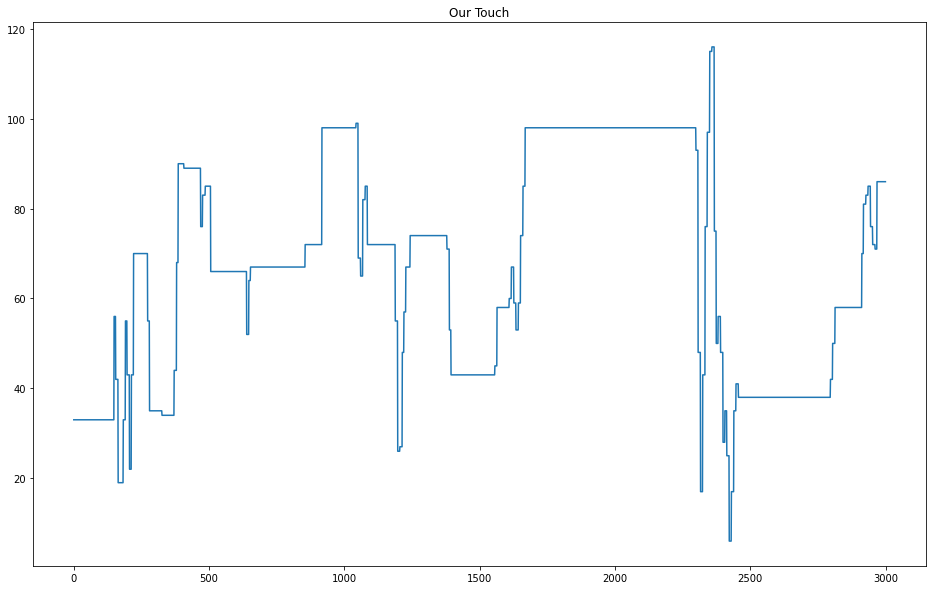

In [ ]:
sample = X_train.iloc[99]

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Our Touch")
plt.show()

# so may normalize the dataset 

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(64, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(4, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3001)]            0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 3001, 1)          0         
 a)                                                              
                                                                 
 gru_1 (GRU)                 (None, 3001, 64)          12864     
                                                                 
 flatten_1 (Flatten)         (None, 192064)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 768260    
                                                                 
Total params: 781,124
Trainable params: 781,124
Non-trainable params: 0
_____________________________________________________

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    batch_size=1,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True
        )
    ]
)

ValueError: ignored

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, label_mapping.keys())
plt.yticks(np.arange(4) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)



In [ ]:
import keras
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()